In [1]:
from pathlib import Path

from matplotlib import pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns

from tqdm.notebook import tqdm

import sentspace

In [2]:
import warnings
warnings.filterwarnings('ignore')

## Functions for loading data

In [3]:
def load_df_from_directory(corpus: str, directory: str, module: str = 'lexical',
                           subsample=True, fmt='pkl.gz'):
    dfs = pd.DataFrame()
    glob = [*Path(directory+'/'+module).resolve().glob(f'sentence-features_part*.{fmt}')]
    if module == 'syntax':
        glob += [*Path(directory+'/'+module).resolve().glob(f'token-features_part*.{fmt}')]

    for path in glob:
        if 'pkl' in fmt: 
            df = pd.read_pickle(path)
        else:
            df = pd.read_csv(path, sep='\t')
        dfs = pd.concat([dfs,df])

    # reassigning the index as a column rather than just an index 
    # (input files can have sentence as their index)
    dfs[dfs.index.name] = dfs.index
    dfs['corpus'] = corpus
    dfs['module'] = module
    dfs['sentence_length'] = dfs['sentence'].apply(lambda x: len(sentspace.Sentence(x, warn=False)))
    # dfs.reset_index(inplace=True, drop=True)
    if subsample:
        return dfs.sample(frac=.3)
    return dfs

In [4]:
def load_benchmarks(module='lexical', subsample=False,
                    include_corpora=False,
                    prefix='.'):
    if prefix: prefix += '/'
    df = pd.DataFrame()
    df = df.append(load_df_from_directory('gpt_stories', prefix+'out/CR_gpt-generated', 
                                          module=module, subsample=subsample))
    df = df.append(load_df_from_directory('human_stories', prefix+'out/gpt2stories_sents_target1', 
                                          module=module, subsample=subsample))
    if include_corpora: 
        df = df.append(load_df_from_directory('brown', prefix+'out/benchmarks/brown_subsampled_grouped_by_length_n=500_stimuli', 
                                            module=module, subsample=subsample))
        df = df.append(load_df_from_directory('torontoadv', prefix+'out/benchmarks/torontoadv_subsampled_grouped_by_length_n=500_stimuli', 
                                            module=module, subsample=subsample))
        df = df.append(load_df_from_directory('wsj', prefix+'out/benchmarks/wsj_subsampled_grouped_by_length_n=500_stimuli', 
                                            module=module, subsample=subsample))
        df = df.append(load_df_from_directory('ud', prefix+'out/benchmarks/ud_subsampled_grouped_by_length_n=500_stimuli', 
                                            module=module, subsample=subsample))
        df = df.append(load_df_from_directory('c4', prefix+'out/benchmarks/c4_subsampled_grouped_by_length_n=500_stimuli', 
                                            module=module, subsample=subsample))
        df = df.append(load_df_from_directory('cocaspok1991', prefix+'out/benchmarks/cocaspok1991_subsampled_grouped_by_length_n=500_stimuli', 
                                            module=module, subsample=subsample))
        df = df.append(load_df_from_directory('cocaspok2001', prefix+'out/benchmarks/cocaspok2001_subsampled_grouped_by_length_n=500_stimuli', 
                                            module=module, subsample=subsample))
        df = df.append(load_df_from_directory('cocaspok2012', prefix+'out/benchmarks/cocaspok2012_subsampled_grouped_by_length_n=500_stimuli', 
                                            module=module, subsample=subsample))
    
    return df

In [5]:
df_gpt_hum_lexical = load_benchmarks(module='lexical', subsample=False)
df_gpt_hum_contextual = load_benchmarks(module='syntax', subsample=False)

In [6]:
def plot_corr_heatmap(corr_obj):
    plt.figure(figsize=(10,10))
    ax = sns.heatmap(corr_obj, vmin=-1, vmax=1, cmap='RdBu_r', square=True, center=0, annot_kws={'size': 14},
                    #  mask=np.triu(corr_obj)
                     )
    plt.xticks(rotation=45, ha='right', rotation_mode='anchor')
    return ax

## t-test for differences across human and GPT-2-XL generated text

In [7]:
from scipy.stats import ttest_ind
def t_test(mixed_df, feature):
    mixed_df.index.name = None
    human = mixed_df.query('corpus == "human_stories"').groupby('sentence').mean().sort_values('index')
    gpt = mixed_df.query('corpus == "gpt_stories"').groupby('sentence').mean().sort_values('index')
    source = np.repeat(human.index.values, 5)
    gpt['source'] = source
    gpt = gpt.groupby('source').mean()[feature].values
    
    assert len(human) == len(gpt), (human.shape, gpt.shape)
    tt, p = ttest_ind(human[feature].values, gpt)
    return tt, p

In [8]:
for col in df_gpt_hum_lexical:
    try:
        print(col, t_test(df_gpt_hum_lexical, col))
    except:
        print(col, 'is in an unsupported format for t-test')
        continue

index (-9.705085226070043, 3.6621685744475236e-16)
content_word (1.149393328500846, 0.25308181712669436)
NRC_Arousal (-1.1623240382479163, 0.24781623842686903)
NRC_Valence (-0.6605100099466349, 0.5104155535130693)
OSC (-0.890410371098158, 0.3753409812448548)
aoa (-0.23197072348069644, 0.8170255147939917)
concreteness (4.235635876169776, 5.003670894863426e-05)
lexical_decision_RT (1.6331920190779718, 0.10551183114102923)
log_contextual_diversity (-2.1376121436355326, 0.03493772639586293)
log_lexical_frequency (-2.9155424666897347, 0.004365762045933808)
n_orthographic_neighbors (-1.01606229829856, 0.31200379682433343)
prevalence (1.2259017261236418, 0.22305848744759268)
surprisal-3 (2.9135408037523365, 0.004391651395756038)
surprisal-1 (3.638120161825709, 0.0004328775153663571)
surprisal-2 (3.769368705175358, 0.00027440473551418304)
surprisal-4 (0.1319607793140838, 0.8952752674114846)
total_degree_centrality (-1.011548939187766, 0.3141473340774095)
polysemy (-0.26938287658496385, 0.78817

In [9]:
for col in df_gpt_hum_contextual:
    try:
        print(col, t_test(df_gpt_hum_contextual, col))
    except:
        print(col, 'is in an unsupported format for t-test')
        continue

index (-9.705085226070043, 3.6621685744475236e-16)
sentence is in an unsupported format for t-test
pronoun_ratio (-0.6774739695651137, 0.49963905673025844)
content_ratio (2.344766619183789, 0.020975750985103986)
dltdc (2.0611982065355154, 0.04182787607903374)
dltdcv (1.5112163247996948, 0.13382531174346776)
dlt (2.338543543302189, 0.021309731647514225)
dltc (1.2797987600669745, 0.20351916204562281)
dltcv (1.3433319274433473, 0.18214566124637568)
dltv (2.6296534620551113, 0.009869949192833391)
dltm (2.654221836675622, 0.009222965145086097)
dltcm (1.59562811629136, 0.11366568175165286)
dltcvm (1.6696935514858122, 0.09804632378664453)
dltvm (2.962472936497631, 0.003797588079088301)
punc (0.7257370726047582, 0.4696618785286004)
dlts (-1.1525105660998582, 0.25180525297151374)
dr (2.5273724196563796, 0.013027009560717775)
drv (1.0383050470569752, 0.3015831770052678)
noF (2.4923053789016194, 0.014302192570175372)
yesJ (-0.768672173751102, 0.44386408819356715)
embddepthAny (1.385889553432214, 

## Section for plotting the correlations heatmap across features

First, we define a mapping from existing feature names to "pretty" feature names as described in the paper

In [10]:
column_labels = {'index': None,             
                 'content_word': None, #'Content Words',
                 'NRC_Arousal': 'Arousal',
                 'NRC_Valence': 'Valence',
                 # NRC Dominance: 'Dominance',
                 'OSC': 'Ortho.-Semantics Consistency',
                 'aoa': 'Age of Acquisition',
                 'concreteness': 'Concreteness',
                 'lexical_decision_RT': 'Lexical Decision RT',
                 'log_contextual_diversity': 'Log Contextual Diversity',
                 'log_lexical_frequency': 'Log Lexical Frequency',
                 'n_orthographic_neighbors': 'Ortho. Neighbor Frequency',
                 'prevalence': 'Prevalence',
                 'surprisal-3': '3-gram Surprisal',
                 'surprisal-1': None,
                 'surprisal-2': '2-gram Surprisal',
                 'surprisal-4': '4-gram Surprisal',
                 'total_degree_centrality': 'Lexical Connectivity', # (Degree Centrality)',
                 'polysemy': 'Polysemy',
                 'num_morpheme_poly': 'Number of Morphemes',
                  None:None,
                 'sentence_length': 'Sentence Length',
                 'Unnamed: 0': None,
                 
                 'pronoun_ratio': 'Pronoun Ratio',
                 'content_ratio': 'Content Word Ratio',
                 'dltdc':None,                   'dltdcv':None,
                 
                 'dlt': 'Syntactic Integration Cost',
                 
                 'dltc':None,'dltcv':None,'dltv':None,'dltm':None,'dltcm':None,
                 'dltcvm':None,'dltvm':None,'punc':None,'dlts':None,'dr':None,
                 'drv':None,'noF':"End of Constituent",'yesJ':"End of Center-Embedding",'embddepthAny':None,
                 'embddepthAllnolo':None,'embddepthCC':None,
                 
                 'embddepthMin': 'Syntactic Embedding Depth',
                 
                     'endembdAny':None,           'endembdAllnolo':None,
                      'endembdCC':None,               'endembdMin':"End of multiword center-embedding",
                   'startembdAny':None,        'startenmbdAllnolo':None,
                    'startembdCC':None,             'startembdMin':None,
                         'noF': "End of Constituent",
                         'noFlen': "Length of Constituent",                    
                         'noFdr':None,
                         'noFdrv':None,                  'embdlen':"Length of Multiword Center-Embedding",
                         'embddr':None,                  'embddrv':None,
                      'reinstlen':None,                 'reinstdr':None,
                      'reinstdrv':None,
}

Construct `df_all`, a concatenation of `lexical` and `contextual` features for GPT2-XL and Humans and then rename its columns

In [11]:
df_all = pd.concat([df_gpt_hum_lexical, df_gpt_hum_contextual])

columns = [column_labels.get(col, col) for col in df_all.columns]
df_all.columns = columns
df_all = df_all.drop(columns=[None])

In [12]:
pd.set_option("display.precision", 2)
print(pd.concat([df_all.groupby('corpus').mean().T, df_all.groupby('corpus').std().T], axis=1).to_latex())

\begin{tabular}{lrrrr}
\toprule
corpus &  gpt\_stories &  human\_stories &  gpt\_stories &  human\_stories \\
\midrule
Arousal                              &         0.42 &           0.42 &         0.04 &           0.04 \\
Valence                              &         0.62 &           0.62 &         0.05 &           0.04 \\
Ortho.-Semantics Consistency         &         0.77 &           0.76 &         0.04 &           0.04 \\
Age of Acquisition                   &         5.28 &           5.26 &         0.53 &           0.46 \\
Concreteness                         &         2.58 &           2.69 &         0.16 &           0.15 \\
Lexical Decision RT                  &       626.59 &         629.34 &        11.02 &           9.30 \\
Log Contextual Diversity             &         3.46 &           3.40 &         0.17 &           0.14 \\
Log Lexical Frequency                &         4.48 &           4.36 &         0.27 &           0.20 \\
Ortho. Neighbor Frequency            &       690.

### Plot individual column comparisons across Human and GPT each as a separate pdf file

In [13]:
import plotly.express as px
import plotly
import plotly.io as pio

In [14]:
for featurename in df_gpt_hum_lexical.columns:

  fig = px.box(df_gpt_hum_lexical, y="corpus", x=featurename, 
              color='corpus',
              points='all',
                      )

  pio.write_image(fig, f'{featurename}.pdf', scale=6, width=780, height=300)

In [15]:
for featurename in df_gpt_hum_contextual.columns:

  fig = px.box(df_gpt_hum_contextual, y="corpus", x=featurename, 
              color='corpus',
              points='all',
                      )

  pio.write_image(fig, f'{featurename}.pdf', scale=6, width=780, height=300)

### Plot a heatmap of Pearson correlations between features

In [16]:
df = df_all.groupby('sentence').mean().reset_index().select_dtypes('number')
# df = load_benchmarks(include_corpora=False).select_dtypes(include='number')
# df = df.append(load_benchmarks(module='syntax', include_corpora=False).select_dtypes(include='number'))
# columns = [column_labels[col] for col in df.columns]
# df.columns = columns
# df = df.drop(columns=[None])

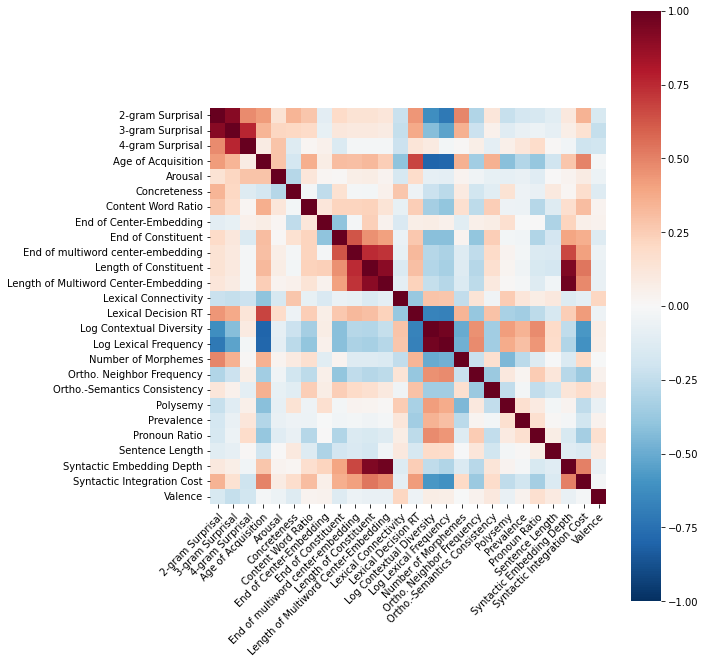

In [17]:
ax = plot_corr_heatmap(df.sort_index(axis=1).corr())
plt.rcParams['svg.fonttype'] = 'none'
plt.tight_layout()
# plt.savefig('heatmap.svg', format='svg')